# Data Challenge

# Importação de Bibliotecas

In [1]:
from glob import glob

# APIs algébricas, matemáticas e para tratamento e manipulação de dados
import numpy as np
import pandas as pd

# APIs para visualização de dados
import matplotlib.pyplot as plt
import seaborn as sns

# Configuração das APIs de visualização
plt.rcParams.update({'figure.figsize': (13,13)})

# APIs para aprendizado de máquina
#import tensorflow as tf
!pip install -U ppscore
import ppscore as pps
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

Requirement already up-to-date: ppscore in c:\users\tiago\anaconda3\lib\site-packages (1.2.0)


# Set de configurações de formatação

In [2]:
plt.style.use('default')

plt.rcParams.update({
    'font.size': 16,
    'axes.linewidth': 2,
    'axes.titlesize': 20,
    'axes.edgecolor': 'black',
    'axes.labelsize': 20,
    'axes.grid': True,
    'lines.linewidth': 1.5,
    'lines.markersize': 6,
    'figure.figsize': (15, 6),
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'font.family': 'Arial',
    'legend.fontsize': 13,
    'legend.framealpha': 1,
    'legend.edgecolor': 'black',
    'legend.shadow': False,
    'legend.frameon': True,
    })

# Obtendo DataFrame

In [3]:
dataFiles = sorted(glob('Training/Small/Sample**.csv'))

In [4]:
dataFiles.extend(sorted(glob('Training/Large/Sample**.csv')))

In [5]:
#Criando dataFrames para cada arquivo
dataFrames = []

particleSizeData = pd.read_csv('Training/Training Operation Profiles of Samples.csv', ';')
particleSizeData.append(pd.read_excel('Validation/Validation Operation Profiles of Samples.xlsx'))
for file in dataFiles:
    df = pd.read_csv(file)
    df["Pressure_Diferential(psi)"] = df["Upstream_Pressure(psi)"] - df["Downstream_Pressure(psi)"] #Calculo da perda de Carga
    df["sample"] = int(file[-6:-4])
    df.join(particleSizeData.set_index('sample'), on='sample')
    first_occurence = df[df['Pressure_Diferential(psi)']>20].index[0]
    df = df.iloc[:first_occurence]
    dataFrames.append(df)
    

In [6]:
# #Encontrando o primeiro valor com perda de carga maior que 20 psi
# limits = []
# for df in dataFrames:
#     for value,time in zip(df['threshold'],df['Time(s)']):
#         if (value == 1) :
#             limits.append(time)
#             break;

In [7]:
#Criando coluna de vida util remanscente
# for df,limit in zip(dataFrames, limits):
#     df['Remaining Lifespan(s)'] = [(limit - instant) if (instant < limit) else 0 for instant in df['Time(s)']];

#Criando coluna de vida util remanscente
for df in dataFrames:
    lastTime = df['Time(s)'].iloc[[-1]]
    df['Remaining_Lifespan(s)'] = [(lastTime.values[0] - instant) for instant in df['Time(s)']];

In [8]:
#Unindo dataframes em um único
dataFrame = pd.concat(dataFrames).reset_index();

In [9]:
import numpy
randnums = [*numpy.random.randint(1,16,3), *numpy.random.randint(33,48,3)]
dataFrames_test = []
for sample in randnums:
    dataFrames_test.append(dataFrame.loc[dataFrame['sample'] == sample])
    
dataFrame_test = pd.concat(dataFrames_test).reset_index();
df_test = dataFrame_test.drop(columns=['sample', 'index', 'level_0'])
y_test = df_test['Remaining_Lifespan(s)']
df_test = df_test.loc[:, df_test.columns != 'Remaining_Lifespan(s)']

# Análise Exploratória dos Dados

In [10]:
dataFrame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54065 entries, 0 to 54064
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   index                      54065 non-null  int64  
 1   Time(s)                    54065 non-null  float64
 2   Flow_Rate(ml/m)            54065 non-null  float64
 3   Upstream_Pressure(psi)     54065 non-null  float64
 4   Downstream_Pressure(psi)   54065 non-null  float64
 5   Pressure_Diferential(psi)  54065 non-null  float64
 6   sample                     54065 non-null  int64  
 7   Remaining_Lifespan(s)      54065 non-null  float64
dtypes: float64(6), int64(2)
memory usage: 3.3 MB


In [11]:
dataFrame.describe()

,index,Time(s),Flow_Rate(ml/m),Upstream_Pressure(psi),Downstream_Pressure(psi),Pressure_Diferential(psi),sample,Remaining_Lifespan(s)
count,54065.000000,54065.000000,54065.000000,54065.000000,54065.000000,54065.000000,54065.000000,54065.000000
mean,1153.443281,115.344328,535.597983,2.875412,0.018119,2.857293,20.017978,115.344328
std,696.405939,69.640594,91.033485,3.896435,0.705578,3.856700,16.205145,69.640594
min,0.000000,0.000000,-3.687368,-1.281250,-1.937500,-0.731250,1.000000,0.000000
25%,563.000000,56.300000,548.810968,0.831250,-0.618750,0.868750,5.000000,56.300000
50%,1126.000000,112.600000,559.274578,1.712500,0.125000,1.600000,11.000000,112.600000
75%,1689.000000,168.900000,564.012816,3.106250,0.668750,2.937500,37.000000,168.900000
max,2774.000000,277.400000,931.325003,20.937500,1.431250,19.981250,44.000000,277.400000


In [12]:
Df = dataFrame.assign(Particles=1)
Df.loc[((Df['sample']>=1) & (Df['sample']<=16)),'Particles'] = 'Small'
Df.loc[((Df['sample']>=33) & (Df['sample']<=48)),'Particles'] = 'Large'
Df.loc[((Df['sample']>=1) & (Df['sample']<=16)),'Particle Size(micron)'] = '45-53'
Df.loc[((Df['sample']>=33) & (Df['sample']<=48)),'Particle Size(micron)'] = '63-75'
Df


,index,Time(s),Flow_Rate(ml/m),Upstream_Pressure(psi),Downstream_Pressure(psi),Pressure_Diferential(psi),sample,Remaining_Lifespan(s),Particles,Particle Size(micron)
0,0,0.0,9.935067,-0.30000,-1.10625,0.80625,1,273.3,Small,45-53
1,1,0.1,4.110983,0.61250,-0.34375,0.95625,1,273.2,Small,45-53
2,2,0.2,5.098116,1.05625,-0.08125,1.13750,1,273.1,Small,45-53
3,3,0.3,10.231207,1.20000,0.84375,0.35625,1,273.0,Small,45-53
4,4,0.4,8.355655,0.93125,0.79375,0.13750,1,272.9,Small,45-53
...,...,...,...,...,...,...,...,...,...,...
54060,1816,181.6,409.526503,18.34375,-0.00625,18.35000,44,0.4,Large,63-75
54061,1817,181.7,413.869888,20.35625,0.83125,19.52500,44,0.3,Large,63-75
54062,1818,181.8,407.947090,19.21875,-0.62500,19.84375,44,0.2,Large,63-75
54063,1819,181.9,412.882755,18.73125,-0.15625,18.88750,44,0.1,Large,63-75


In [13]:
#len(Df.loc[((Df['sample']>=1) & (Df['sample']<=12))])
Df_filtred=Df.drop(columns=['index','sample'])
# Df.groupby('Particles')

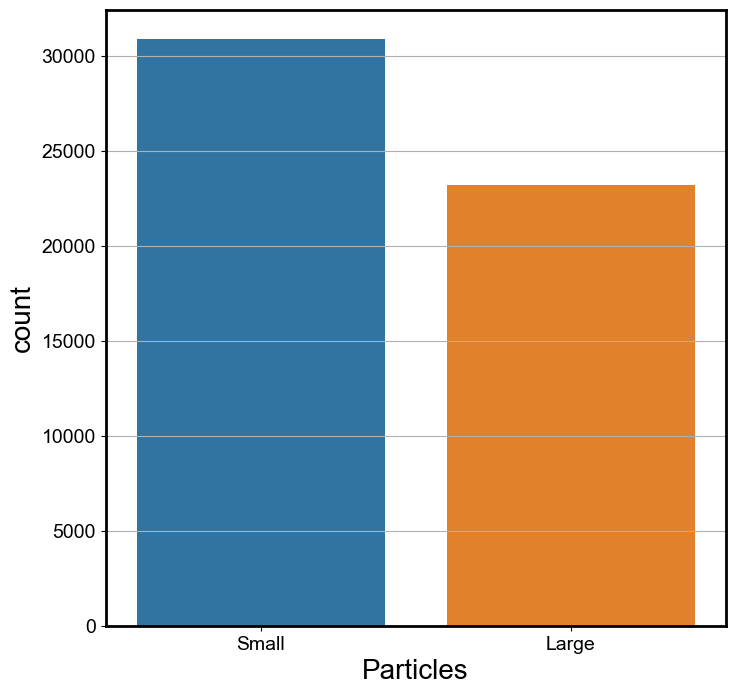

In [14]:
fig, ax = plt.subplots(figsize=(8,8))
sns.countplot(data=Df_filtred, x='Particles', ax=ax)

In [15]:
data_description=Df_filtred.describe()
data_description

,Time(s),Flow_Rate(ml/m),Upstream_Pressure(psi),Downstream_Pressure(psi),Pressure_Diferential(psi),Remaining_Lifespan(s)
count,54065.000000,54065.000000,54065.000000,54065.000000,54065.000000,54065.000000
mean,115.344328,535.597983,2.875412,0.018119,2.857293,115.344328
std,69.640594,91.033485,3.896435,0.705578,3.856700,69.640594
min,0.000000,-3.687368,-1.281250,-1.937500,-0.731250,0.000000
25%,56.300000,548.810968,0.831250,-0.618750,0.868750,56.300000
50%,112.600000,559.274578,1.712500,0.125000,1.600000,112.600000
75%,168.900000,564.012816,3.106250,0.668750,2.937500,168.900000
max,277.400000,931.325003,20.937500,1.431250,19.981250,277.400000


In [16]:
Df_col = ['Time(s)','Flow_Rate(ml/m)',	'Upstream_Pressure(psi)',	'Downstream_Pressure(psi)',	'Pressure_Diferential(psi)',	'Remaining_Lifespan(s)'	,'Particles']
Df_col

['Time(s)',
 'Flow_Rate(ml/m)',
 'Upstream_Pressure(psi)',
 'Downstream_Pressure(psi)',
 'Pressure_Diferential(psi)',
 'Remaining_Lifespan(s)',
 'Particles']

In [17]:
#axes = data_description.T.plot.bar(subplots=True, figsize=(15,10))
Df_filtred.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54065 entries, 0 to 54064
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Time(s)                    54065 non-null  float64
 1   Flow_Rate(ml/m)            54065 non-null  float64
 2   Upstream_Pressure(psi)     54065 non-null  float64
 3   Downstream_Pressure(psi)   54065 non-null  float64
 4   Pressure_Diferential(psi)  54065 non-null  float64
 5   Remaining_Lifespan(s)      54065 non-null  float64
 6   Particles                  54065 non-null  object 
 7   Particle Size(micron)      54065 non-null  object 
dtypes: float64(6), object(2)
memory usage: 3.3+ MB


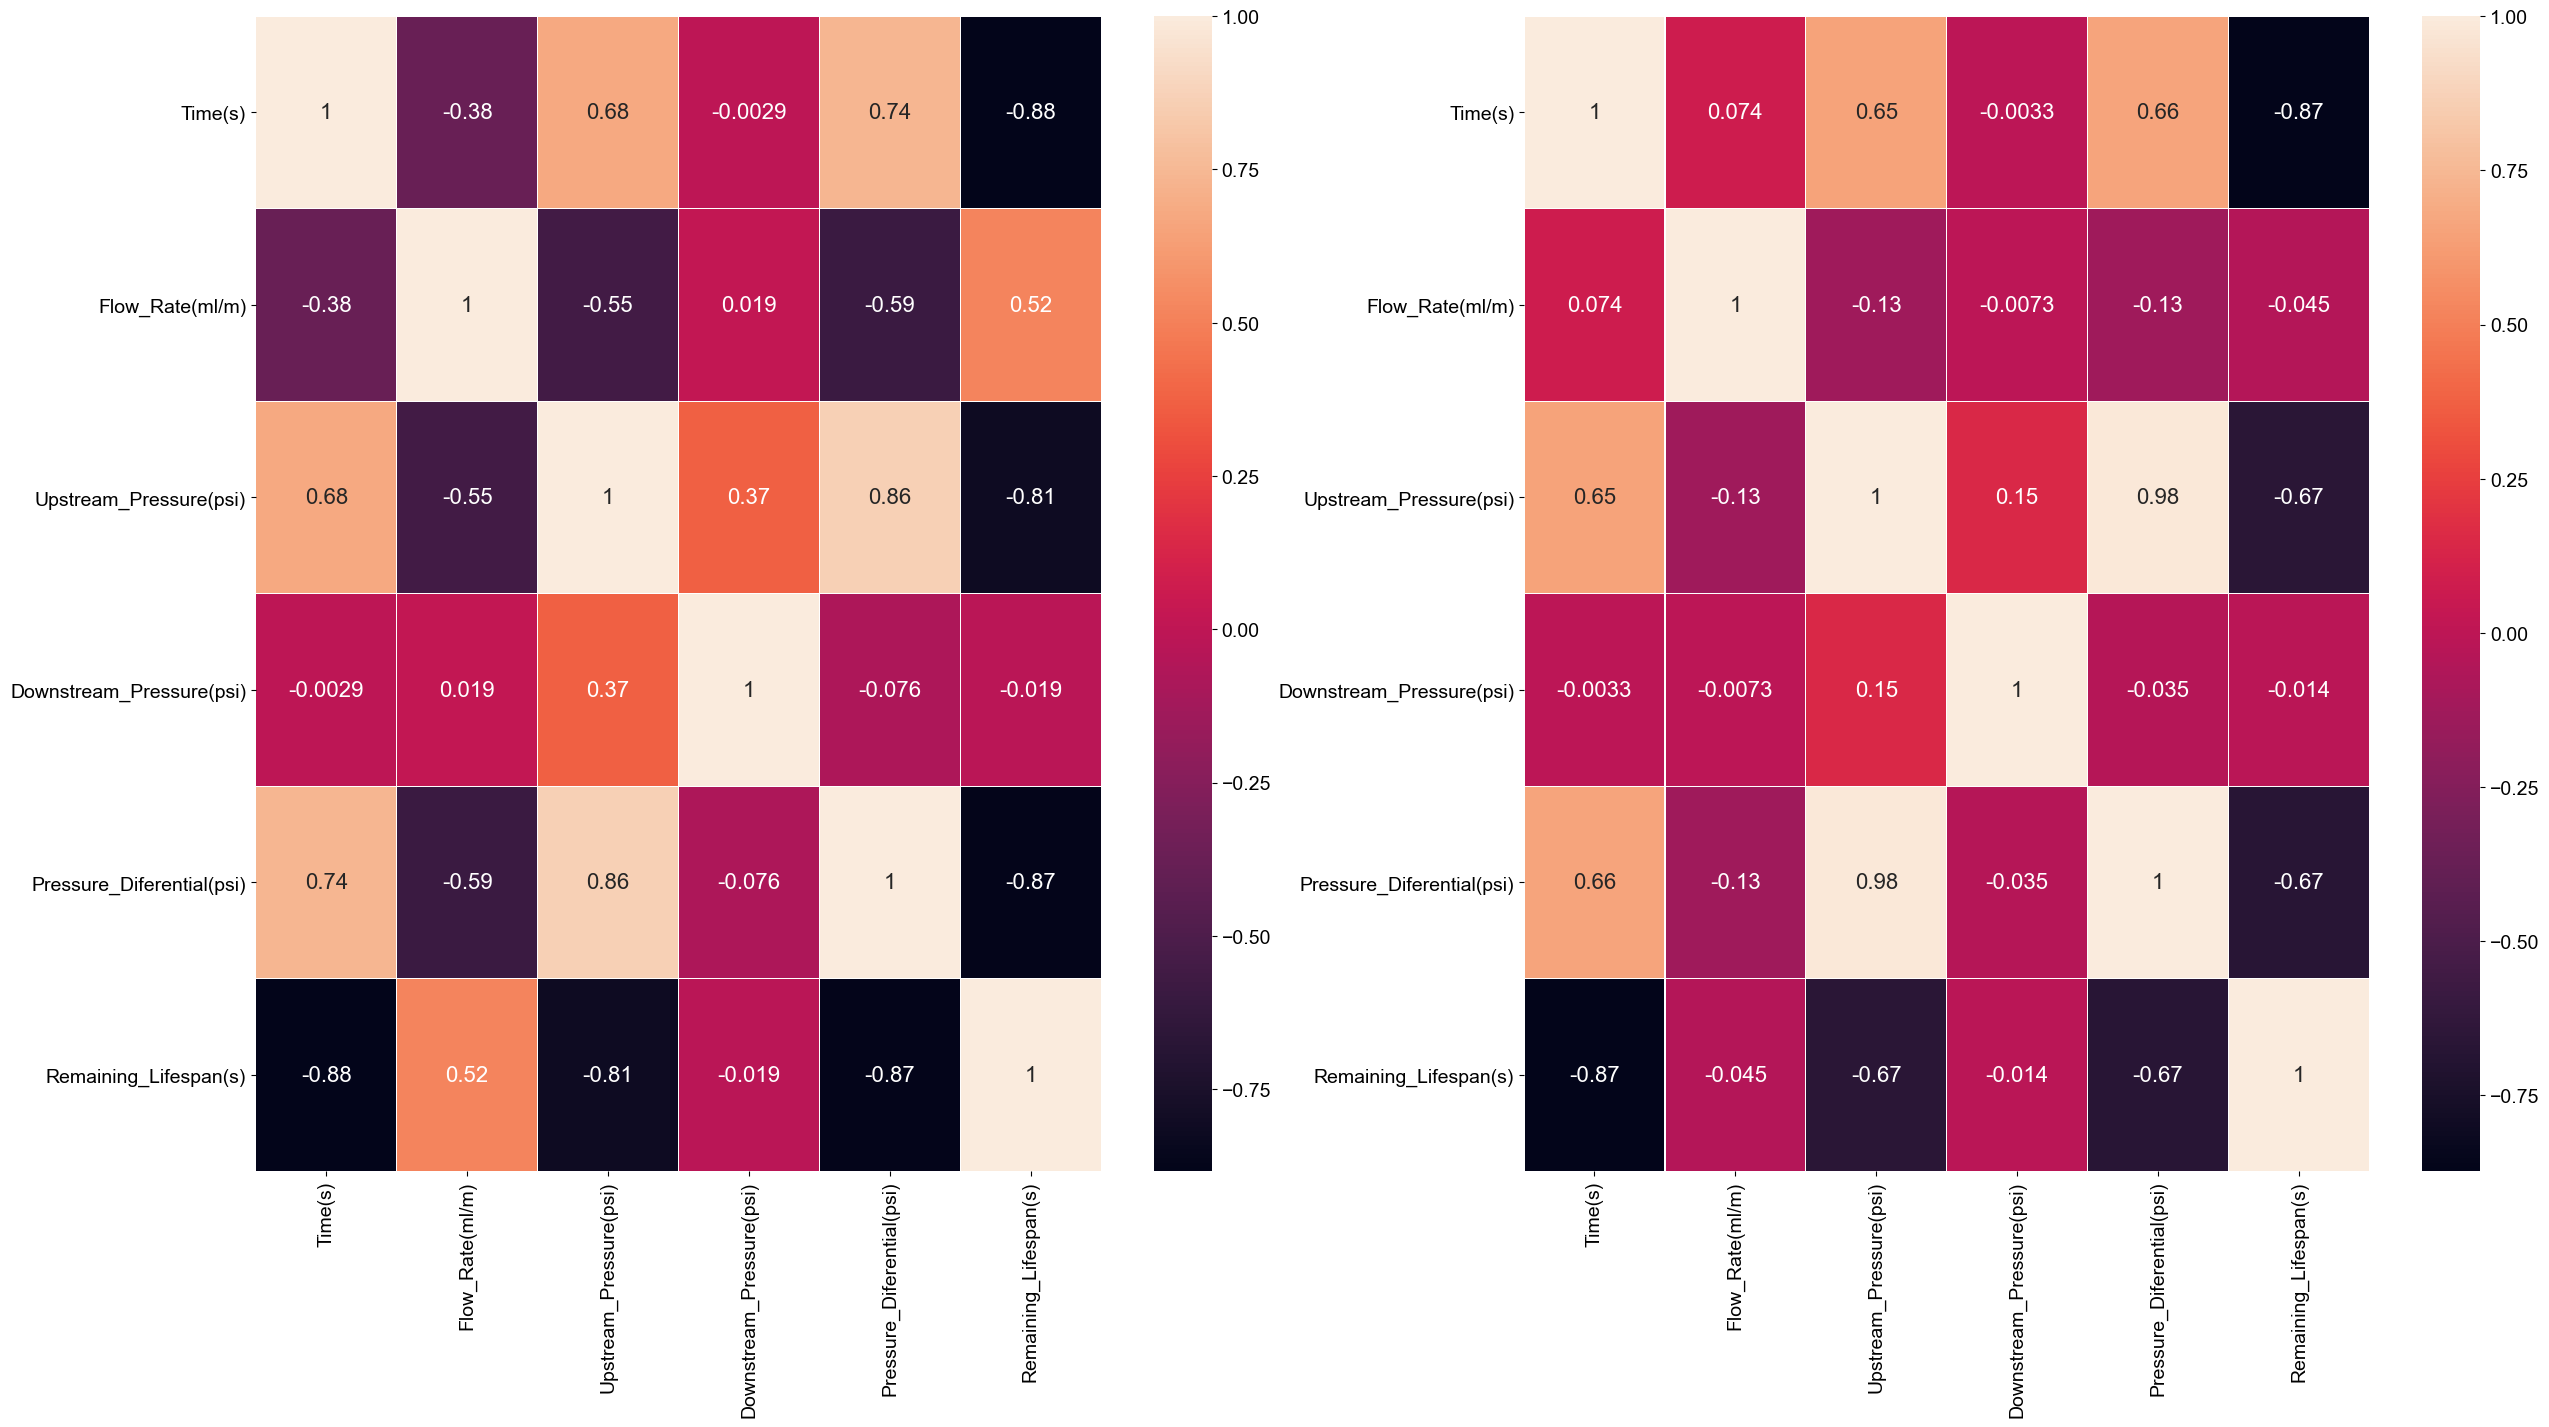

In [18]:
Df_plot = Df_filtred.copy()[Df_col]
df_corr1 = Df_plot.corr(method='spearman')
df_corr2 = Df_plot.corr(method='pearson')
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(30,15))
sns.heatmap(df_corr1, linewidths=.2, annot=True,ax=ax1)
sns.heatmap(df_corr2, linewidths=.2, annot=True,ax=ax2)


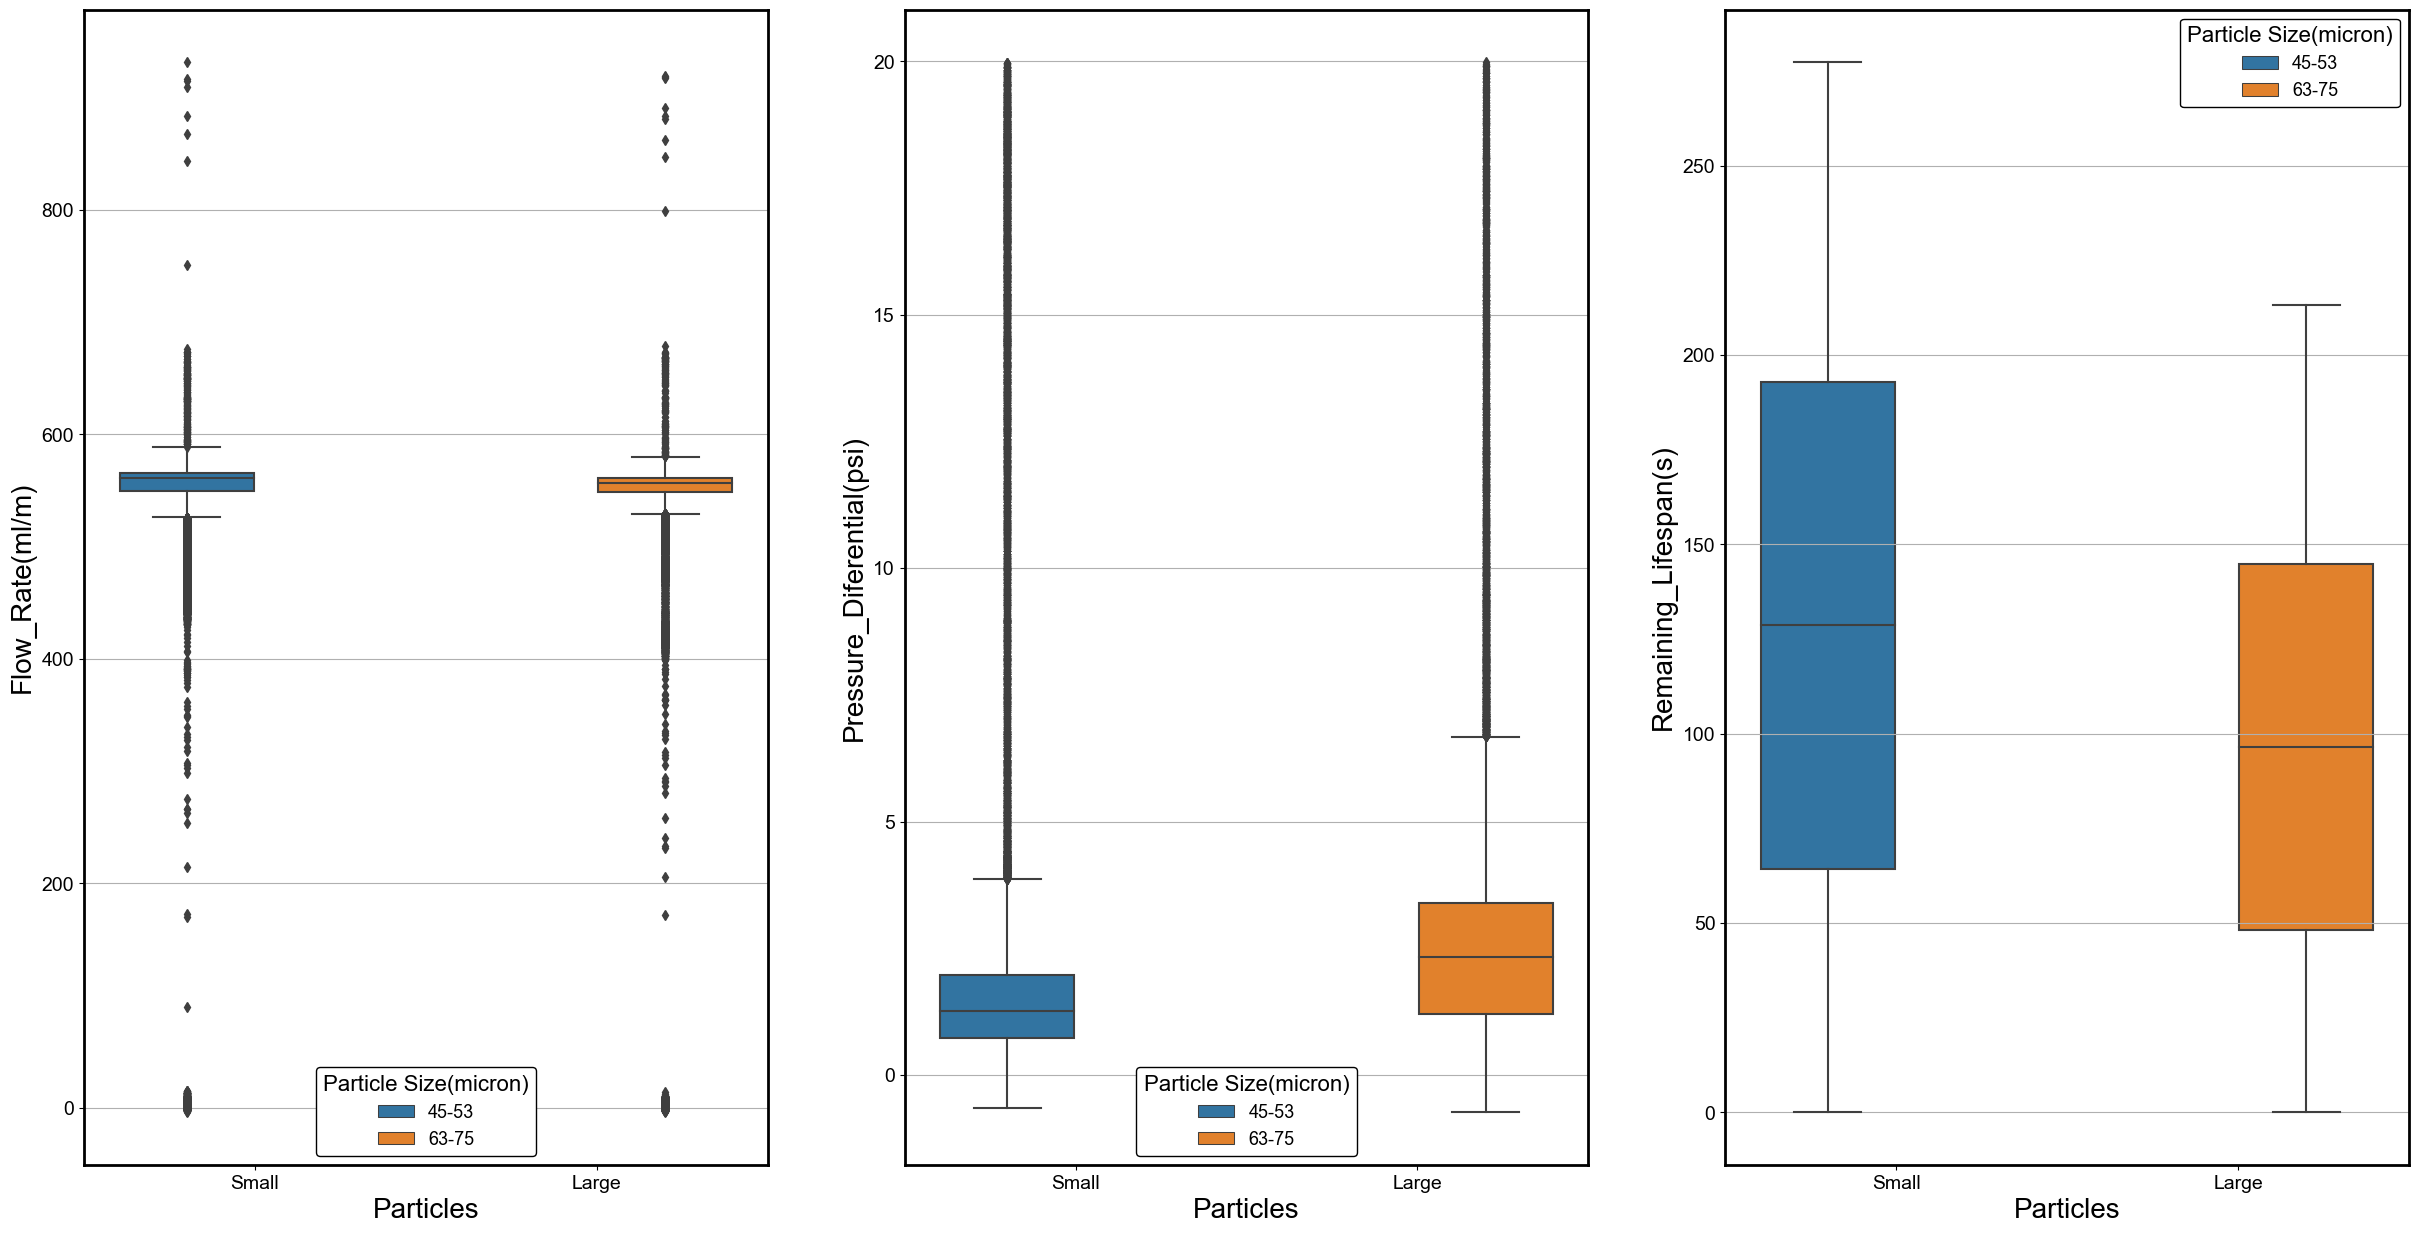

In [19]:
fig, (ax, ax1, ax2) = plt.subplots(1,3,figsize=(30,15))
sns.boxplot(x='Particles',y='Flow_Rate(ml/m)',data=Df_filtred, hue="Particle Size(micron)", ax=ax)
sns.boxplot(x='Particles',y='Pressure_Diferential(psi)',data=Df_filtred, hue="Particle Size(micron)", ax=ax1)
sns.boxplot(x='Particles',y='Remaining_Lifespan(s)',data=Df_filtred, hue="Particle Size(micron)", ax=ax2)

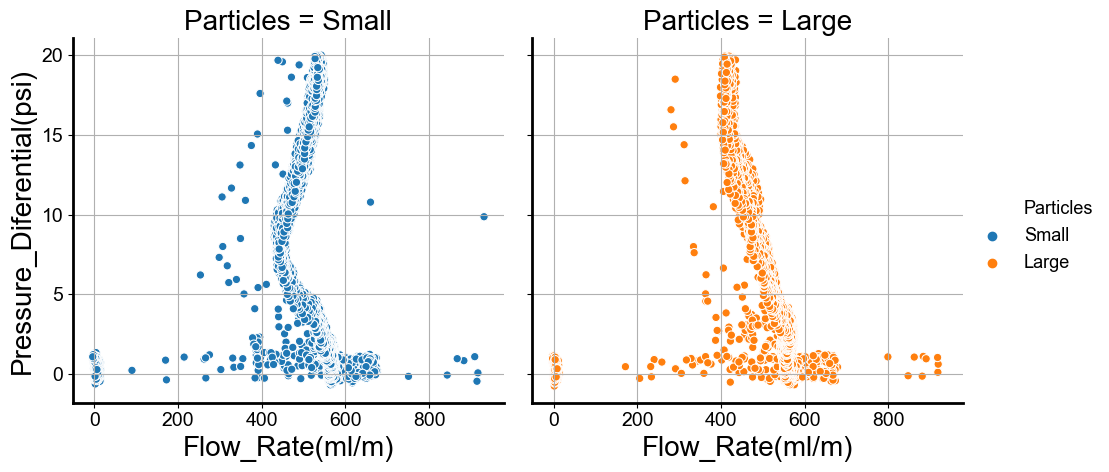

In [52]:
sns.relplot(y="Pressure_Diferential(psi)", x="Flow_Rate(ml/m)",hue="Particles", 
            col="Particles", data=Df);

#(Df.loc[((Df['sample']>=1) & (Df['sample']<=12))])
#sns.relplot(x=Df["Particles"],y=Df["Pressure_Diferential(psi)"],kind="line", data=Df)

In [21]:
Df_filtred["Remaining_Lifespan(s)"].loc[(Df_filtred["Particles"]=="Small")]

0        273.3
1        273.2
2        273.1
3        273.0
4        272.9
         ...  
30882      0.4
30883      0.3
30884      0.2
30885      0.1
30886      0.0
Name: Remaining_Lifespan(s), Length: 30887, dtype: float64

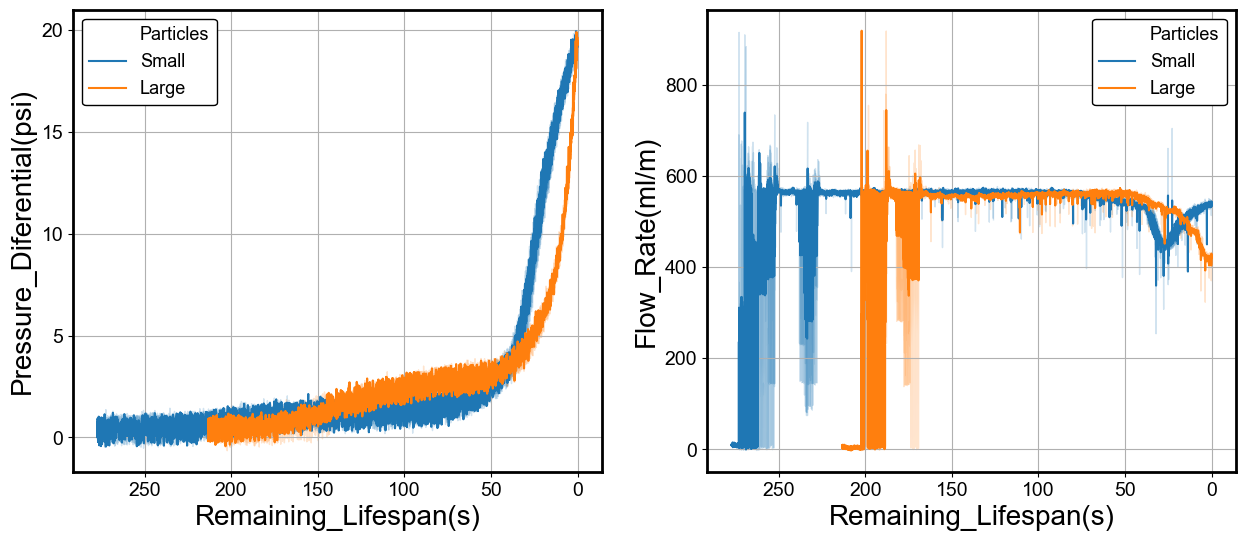

In [22]:
# g=sns.relplot(x="Remaining Lifespan(s)", y="Flow_Rate(ml/m)",hue="Particles", 
#             col="Particles", data=Df);
# g.set(ylim=(200, 700))
# g.invert_xaxis() 

fig, (ax,ax2) = plt.subplots(1, 2)
sns.lineplot(x="Remaining_Lifespan(s)", y="Pressure_Diferential(psi)",ax=ax,hue="Particles", data=Df_filtred)
ax.invert_xaxis()
sns.lineplot (x="Remaining_Lifespan(s)", y="Flow_Rate(ml/m)", ax=ax2, hue="Particles", data=Df_filtred)
ax2.invert_xaxis()

# ax2.plot(Df["Remaining Lifespan(s)"], Df["Flow_Rate(ml/m)"])
# ax2.invert_xaxis()

In [23]:
# fig, ax = plt.subplots(ncols = 1, nrows = len(pressoes), figsize = (10, 5*len(pressoes)))
# ax = ax.reshape((len(pressoes),))
# aux_df = Df.groupby('Particles')

# for pressao in range(len(pressoes)):  
#     ax[pressao].set_title(f'{pressoes[pressao]}', size = 20)
    
#     #sns.scatterplot(data = aux_df, x = 'Remaining Lifespan(s)', y= 'Flow_rate(ml/m)', label = 'Partículas pequenas', hue = 'sample')

#     sns.scatterplot(data = aux_df.get_group(0)[pressoes[pressao]], ax = ax[pressao], label = 'Partículas pequenas')
#     sns.scatterplot(data = aux_df.get_group(1)[pressoes[pressao]], ax = ax[pressao], label = 'Partículas grandes')
    
#     ax[pressao].legend()
#     ax[pressao].grid()

    
# # seaborn
# # hue


In [24]:
Df_filtred["Remaining_Lifespan(s)"].loc[(Df_filtred["Particles"]=='Small')]

0        273.3
1        273.2
2        273.1
3        273.0
4        272.9
         ...  
30882      0.4
30883      0.3
30884      0.2
30885      0.1
30886      0.0
Name: Remaining_Lifespan(s), Length: 30887, dtype: float64

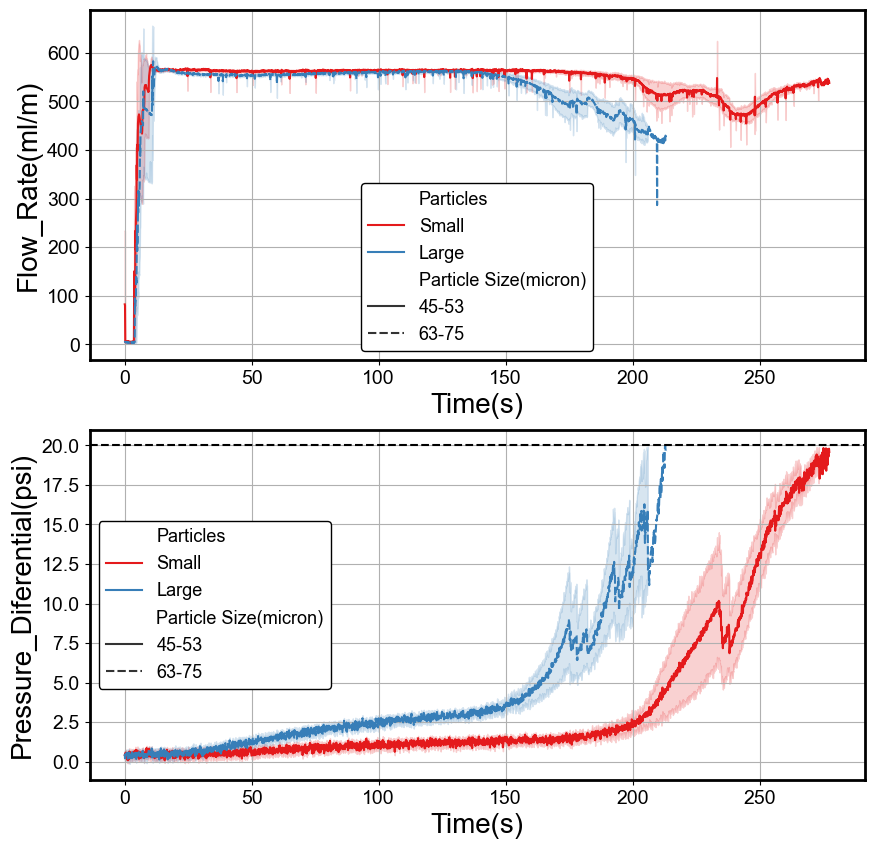

In [25]:
fig, (ax1,ax2) = plt.subplots(2, 1, figsize=(10,10))
sns.lineplot(x = 'Time(s)', y= 'Flow_Rate(ml/m)', hue= 'Particles', style="Particle Size(micron)", palette= 'Set1', ax=ax1, data=Df_filtred)
# # ax1.set(ylim=(300, 700))
# # ax1.set(xlim=(0.1,300))


sns.lineplot(x = 'Time(s)', y= 'Pressure_Diferential(psi)', hue= 'Particles',  style="Particle Size(micron)", palette= 'Set1', ax=ax2, data=Df_filtred)
ax2.axhline(y=20, color='black', linestyle='dashed')
# ax2.set(ylim=(0, 25))
 # ax2.set(xlim=(0.1,300))



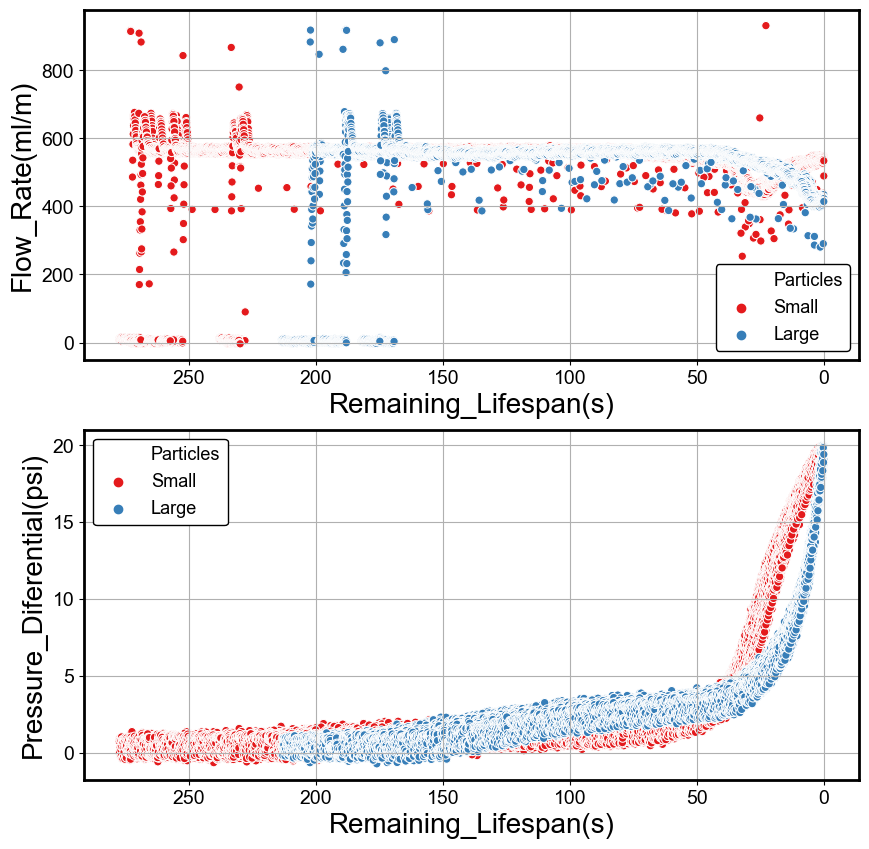

In [26]:
fig, (ax1,ax2) = plt.subplots(2, 1, figsize=(10,10))
sns.scatterplot(x = 'Remaining_Lifespan(s)', y= 'Flow_Rate(ml/m)', hue= 'Particles', palette= 'Set1', ax=ax1, data=Df_filtred)
# ax1.set(ylim=(300, 700))
# ax1.set(xlim=(0.1,300))
ax1.invert_xaxis()

sns.scatterplot(x = 'Remaining_Lifespan(s)', y= 'Pressure_Diferential(psi)', hue= 'Particles', palette= 'Set1', ax=ax2, data=Df_filtred)
# ax2.set(ylim=(0, 25))
# ax2.set(xlim=(0.1,300))
ax2.invert_xaxis()

#hue = 'sample',

# Removendo Outliers

(460.0, 630.0)

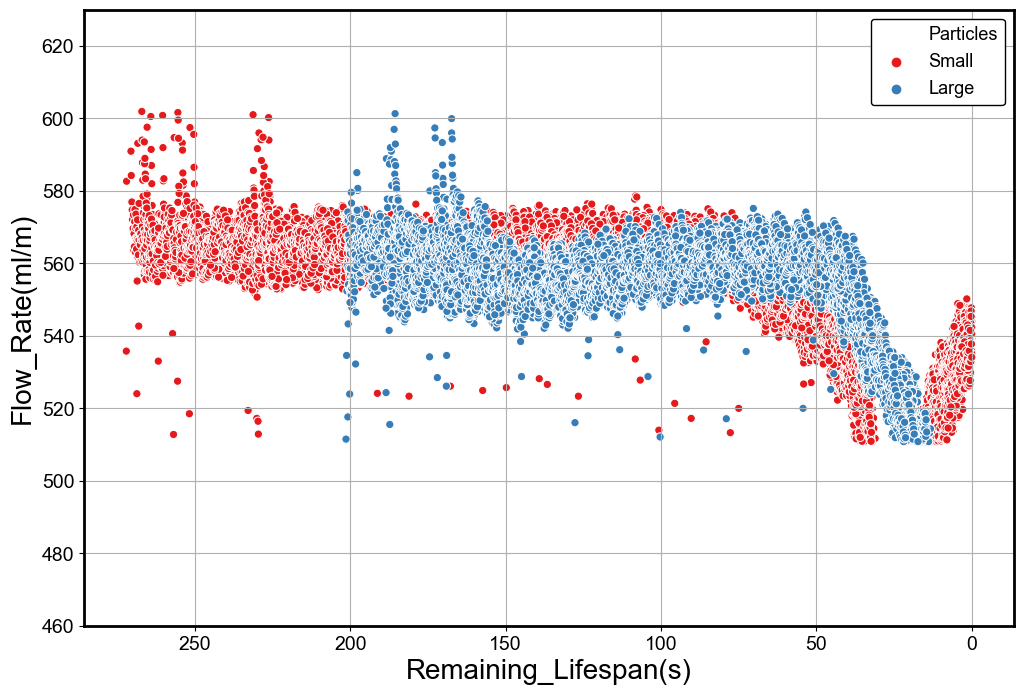

In [46]:
def outlier2nan(df, fator):
    q3, q1 = np.percentile(df, [75, 25])
    iqr = q3 - q1
    lowpass = q1 - (iqr*fator)
    highpass = q3 + (iqr*fator)
    df.loc[(df < lowpass) | (df > highpass)] = np.nan

df_semoutlier = Df_filtred.copy()
outlier2nan(df_semoutlier["Flow_Rate(ml/m)"], 2.5)
df_semoutlier.dropna(inplace=True)

fig, ax1 = plt.subplots(1, 1, figsize=(12,8))
sns.scatterplot(x = 'Remaining_Lifespan(s)', y= 'Flow_Rate(ml/m)', hue= 'Particles', palette= 'Set1', ax=ax1, data=df_semoutlier)
# ax1.set(ylim=(300, 700))
# ax1.set(xlim=(0.1,300))
ax1.invert_xaxis()
plt.ylim([460,630])

In [28]:
Df_filtred["Flow_Rate(ml/m)"]

0          9.935067
1          4.110983
2          5.098116
3         10.231207
4          8.355655
            ...    
54060    409.526503
54061    413.869888
54062    407.947090
54063    412.882755
54064    414.560881
Name: Flow_Rate(ml/m), Length: 54065, dtype: float64

In [29]:
# fig, ax=plt.subplots(figsize=(15,15))
# sns.scatterplot(data = Df_filtred, x = 'Remaining_Lifespan(s)', y= 'Pressure_Diferential(psi)', hue = 'Particles', palette= 'Set1',ax=ax)
# ax.invert_xaxis()

In [30]:
# Df_filtred.loc(Df_filtred["Particles"]==object(small))
Df_filtred.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54065 entries, 0 to 54064
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Time(s)                    54065 non-null  float64
 1   Flow_Rate(ml/m)            54065 non-null  float64
 2   Upstream_Pressure(psi)     54065 non-null  float64
 3   Downstream_Pressure(psi)   54065 non-null  float64
 4   Pressure_Diferential(psi)  54065 non-null  float64
 5   Remaining_Lifespan(s)      54065 non-null  float64
 6   Particles                  54065 non-null  object 
 7   Particle Size(micron)      54065 non-null  object 
dtypes: float64(6), object(2)
memory usage: 3.3+ MB


In [31]:
# sns.lineplot(data = Df_filtred.loc[(Df_filtred['Particles']=="small")], x = 'Remaining_Lifespan(s)', y= 'Flow_Rate(ml/m)', hue= 'Particles', palette= 'Set1')


In [32]:
# sns.scatterplot(data = Df_filtred.loc[(Df_filtred['Particles'])=='Small'], x = 'Remaining_Lifespan(s)', y= 'Flow_Rate(ml/m)', hue = 'sample', style= 'Particles', palette= 'Set1')


In [33]:
# sns.boxplot(x=Df['Particles'],y=[Df['Pressure_Diferential(psi)'], Df['Flow_Rate(ml/m)'], Df['Remaining Lifespan(s)']])

# Aplicação de Modelos

In [34]:
#Separando variáveis dependentes e independentes
#Variável dependente:
df = dataFrame.drop(columns=['sample', 'index'])
y_train = df['Remaining_Lifespan(s)']
X_train = df.loc[:, df.columns != 'Remaining_Lifespan(s)']

# Random Forest Regressor

In [35]:
#Importando Random Forest Regressor
from sklearn.ensemble import RandomForestRegressor

#Criando obj Random Forest Regressor
RFReg = RandomForestRegressor(n_estimators = 10, random_state = 0)

#Fit the random forest regressor with training data represented by X_train and y_train
RFReg.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, random_state=0)

In [36]:
#Teste
#Criando dataFrames para cada arquivo
y_predict_rfr = RFReg.predict(df_test)
y_predict_rfr

array([2.5849e+02, 2.6638e+02, 2.4324e+02, ..., 7.6000e-01, 1.4000e-01,
       1.8000e-01])

In [37]:
from sklearn import metrics
r_square = metrics.r2_score(y_test,y_predict_rfr)
r_square

0.9834516305045203